# CS3244 Project Pg34:
### Baseline CT - Augmented FVC forecasting to project pulmonary fibrosis progression, aiding medical decision-making and prognosis

Insert brief introduction here

### Imports:

Package imports:

In [15]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

Tabular data import:

In [5]:
BASE_DIR = Path.cwd()
csv_path = BASE_DIR / "data" / "train.csv"

data = pd.read_csv(csv_path)
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


## Exploratory Data Analysis/ Image Data Preprocessing

### Tabular Data

Here is the outline of what each columns represent:  
Patient(str): unique ID for each patient  
Weeks(int): the relative number of weeks pre/post the baseline CT scan  
FVC(int): the recorded lung capacity in ml  
Percent(float): a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics  
Age(int), Sex(str), SmokingStatus(str)

For now, FVC readings measured pre-CT scans are dropped, then readings are grouped by patient IDs.

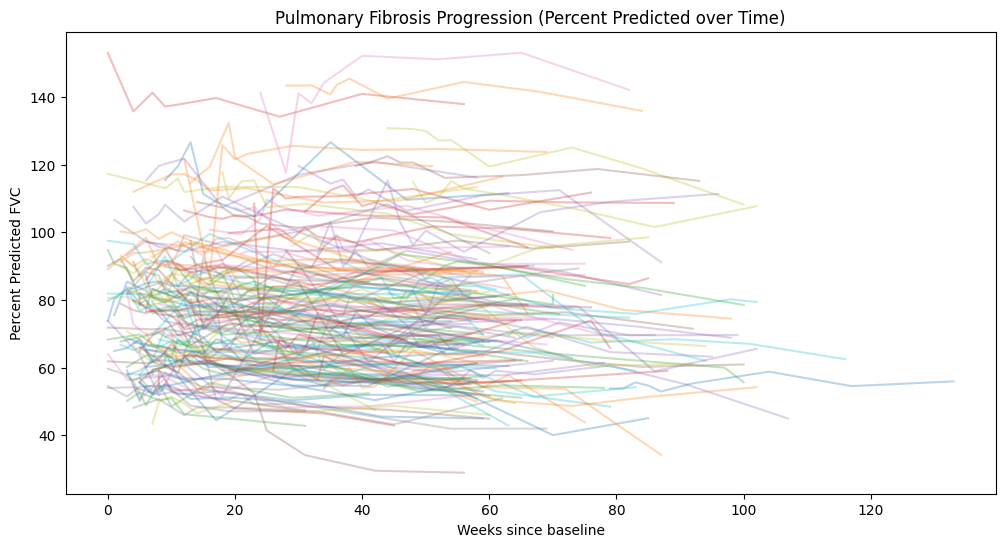

In [9]:
post_CT_data = data[data["Weeks"]>=0]
plt.figure(figsize=(12, 6))

for patient, pdata in post_CT_data.groupby("Patient"):
    plt.plot(pdata["Weeks"], pdata["Percent"], alpha=0.3)

plt.xlabel("Weeks since baseline")
plt.ylabel("Percent Predicted FVC")
plt.title("Pulmonary Fibrosis Progression (Percent Predicted over Time)")
plt.show()

Overall linear trend of decreasing percent values is observed. Now, effect of age is assessed, but there is a limitation: the readings are taken irregularly, so it is challenging to compute a metric that expresses change in FVC from week 30 to week 0. Instead, a percentage decline is computed then plotted.

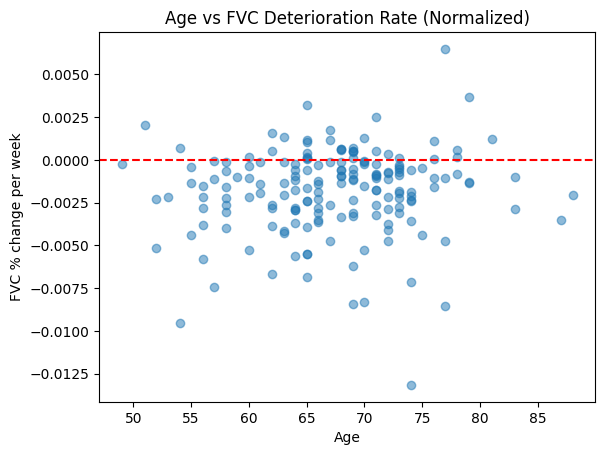

In [10]:
rates = []
ages = []

for patient, pdata in post_CT_data.groupby("Patient"):
    pdata = pdata.sort_values("Weeks")
    fvc_first = pdata["FVC"].iloc[0]
    fvc_last = pdata["FVC"].iloc[-1]
    t_first = pdata["Weeks"].iloc[0]
    t_last = pdata["Weeks"].iloc[-1]
    
    if t_last > t_first:  # avoid divide by zero
        decline_rate = (fvc_last - fvc_first) / (fvc_first * (t_last - t_first))
        rates.append(decline_rate)
        ages.append(pdata["Age"].iloc[0])

plt.scatter(ages, rates, alpha=0.5)
plt.xlabel("Age")
plt.ylabel("FVC % change per week")
plt.title("Age vs FVC Deterioration Rate (Normalized)")
plt.axhline(0, color="red", linestyle="--")
plt.show()

Not much explicit correlation between age and relative FVC decline is shown in this plot. Moving on to sex:

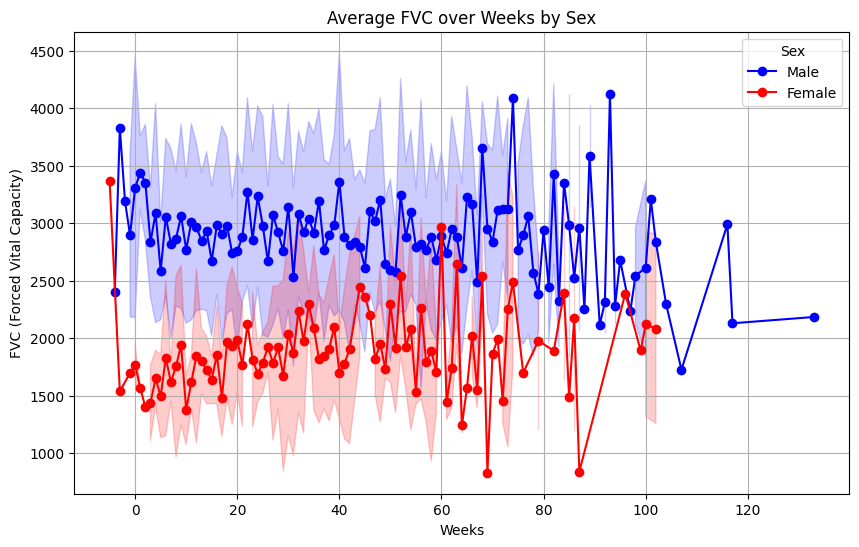

In [11]:
sex_weeks = data.groupby(["Weeks", "Sex"])["FVC"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(10,6))

# Plot Male
male = sex_weeks[sex_weeks["Sex"] == "Male"]
plt.plot(male["Weeks"], male["mean"], label="Male", color="blue", marker="o")
plt.fill_between(male["Weeks"], male["mean"] - male["std"], male["mean"] + male["std"],
                 alpha=0.2, color="blue")

# Plot Female
female = sex_weeks[sex_weeks["Sex"] == "Female"]
plt.plot(female["Weeks"], female["mean"], label="Female", color="red", marker="o")
plt.fill_between(female["Weeks"], female["mean"] - female["std"], female["mean"] + female["std"],
                 alpha=0.2, color="red")

plt.title("Average FVC over Weeks by Sex")
plt.xlabel("Weeks")
plt.ylabel("FVC (Forced Vital Capacity)")
plt.legend(title="Sex")
plt.grid(True)
plt.show()


The blue line (Male) is consistently higher than the red line (Female) which matches expectations since on average, males have larger lung volumes than females due to physiological differences (height, chest size, etc.).

Males (blue band) show larger variability in FVC compared to females. This means some males decline much faster/slower than others, while female patients are more tightly clustered around the average, suggesting more heterogeneity in the disease course of male patients. Most importantly, the rate of decline looks similar for both sexes.

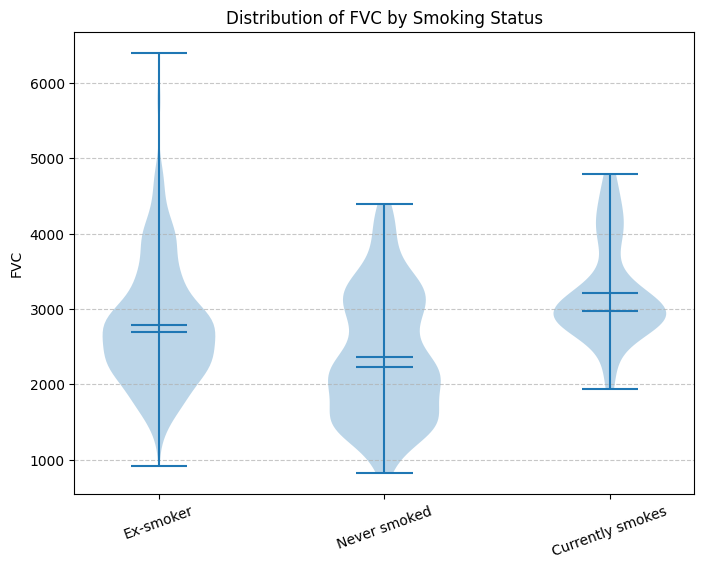

In [12]:
groups = [data.loc[data["SmokingStatus"] == status, "FVC"].dropna() 
          for status in data["SmokingStatus"].unique()]
labels = data["SmokingStatus"].unique()

plt.figure(figsize=(8,6))
plt.violinplot(groups, showmeans=True, showmedians=True)
plt.xticks(range(1, len(labels)+1), labels, rotation=20)
plt.title("Distribution of FVC by Smoking Status")
plt.ylabel("FVC")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()

Patients who currently smoke generally exhibit higher FVC values than those who have never smoked, while ex-smokers show a wider distribution with more variability and some very low values. This suggests that smoking history influences lung function, but the relationship is not entirely linear. Current smokers not always showing the lowest FVC, possibly due to sample variation or confounding factors such as age or disease severity.

### Image Data

## Baseline Unimodal Models

### Tabular Data: XGBoost

For the first baseline model, the longitudinal data is coerced into a single row to be pipelined into a simpler XGBoost model.

In row coercion, linearity is assumed and the grouped dataframe is collapsed by computing three features:
1. $\Delta t$ : the change in time from the second last reading from the first reading
2. $\Delta$ FVC : the change in FVC from the second last reading from the first reading
3. next_time : the change in time from the last reading which is being predicted to the second last reading

Then, the label will be the FVC reading from the last reading.

XGBoost Baseline Results:
MAE: 522.998291015625
R²: 0.23963278532028198


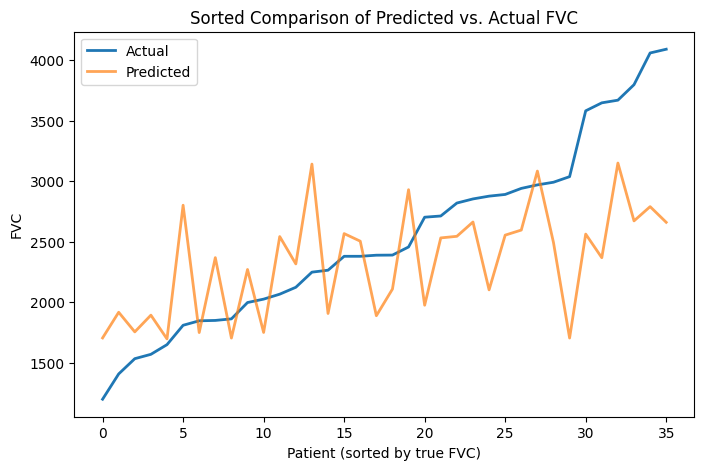

In [21]:
sys.path.insert(0, str(BASE_DIR / "late_fusion"))
from baseline import X_train, X_val, y_train, y_val, baseline

# Train the model
baseline.fit(X_train, y_train)

baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_val)
print(f"XGBoost Baseline Results:")
print("MAE:", mean_absolute_error(y_val, y_pred))
print("R²:", r2_score(y_val, y_pred))

order = np.argsort(y_val)
y_true_sorted = np.array(y_val)[order]
y_pred_sorted = np.array(y_pred)[order]

plt.figure(figsize=(8, 5))
plt.plot(y_true_sorted, label="Actual", lw=2)
plt.plot(y_pred_sorted, label="Predicted", lw=2, alpha=0.7)
plt.title("Sorted Comparison of Predicted vs. Actual FVC")
plt.xlabel("Patient (sorted by true FVC)")
plt.ylabel("FVC")
plt.legend()
plt.show()

### Image Data:

## Approach 1: Early Fusion

## Approach 2: Late Fusion